# Example 3 : Basic Analysis and Identifying Potential Events

In this notebook we will go through a basic perscription for analyzing MUSIC data. This typically involves a series of steps to search for the events of interest within the larger dataset. Finding the proverbial needle in the haystack (typically, by trying to reduce the size of the "haystack" first). For example, one set of steps could look something like

- Cut Pile-up Events
- Normalization
- Remove Bulk of Unreacted Beam Events
- Apply Cuts in Different Strips
- Plot Traces

Let's work through these steps using test MUSIC data and see what the effect of each step is on the dataset. First our usual notebook setup.

<div class="alert alert-block alert-info">
Is this the "best" order for these operations? It depends on what kind of experiment you performed. For example, in the test data we are looking for fusion events from $^{20}$Ne beam on CH$_{4}$ gas. One potential problem being, some elastic scatter reactions will look very much like fusions. So, an extra step might involve using the left and right anode strips (not summing them) to get the multiplicty in the strips for certain events. So, take the above perscription as an idea but not something set in stone to follow exactly.
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 # bigger figures

# Use more REVTEX-esque fonts
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"

# Use UPROOT and Pull the Data Into a Pandas Dataframe

Following directly from our work in example 2, we will use uproot to read the test_music_data.ROOT file and build a pandas dataframe.

In [2]:
import uproot

In [3]:
file = uproot.open("test_music_data.root")
tree = file['tree']
branches = tree.arrays()

One slight change we will make here is in addition to pulling the individual strip information into the dataframe, we will also bring the grid information too. The Frisch grid signal is similar to a total energy of the given event (so, we can use it as an additional source of information to help identify the reactions we are looking for).

In [4]:
dict_branches = {}

# strip0 first
dict_branches.update({'s0':branches['strip0'][branches['seg'] == 1]})
# segmented anode, left first then right
for i in range(1,17):
    dict_branches.update({'s%iL' % i : branches['edepl'][branches['seg'] == i]})
    dict_branches.update({'s%iR' % i  : branches['edepr'][branches['seg'] == i]})
# strip17
dict_branches.update({'s17':branches['strip17'][branches['seg'] == 1]})
# grid last
dict_branches.update({'grid':branches['grid'][branches['seg'] == 1]})

In [5]:
df = pd.DataFrame(dict_branches)

df

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17,grid
0,1003.0,366.0,50.0,35.0,366.0,387.0,33.0,42.0,335.0,377.0,...,463.0,34.0,35.0,457.0,462.0,33.0,49.0,445.0,402.0,1522.0
1,1091.0,356.0,41.0,37.0,366.0,376.0,32.0,36.0,361.0,368.0,...,429.0,37.0,41.0,522.0,470.0,32.0,40.0,482.0,380.0,1468.0
2,1083.0,364.0,62.0,36.0,359.0,371.0,35.0,38.0,372.0,365.0,...,447.0,37.0,38.0,501.0,471.0,32.0,39.0,483.0,402.0,1421.0
3,1002.0,362.0,43.0,37.0,341.0,359.0,35.0,37.0,380.0,411.0,...,436.0,36.0,37.0,442.0,470.0,33.0,37.0,467.0,400.0,1450.0
4,1015.0,352.0,41.0,37.0,361.0,377.0,33.0,39.0,382.0,409.0,...,444.0,33.0,37.0,441.0,442.0,34.0,43.0,463.0,366.0,1487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,338.0,63.0,36.0,360.0,381.0,37.0,36.0,377.0,419.0,...,425.0,39.0,33.0,434.0,419.0,35.0,39.0,459.0,403.0,1592.0
267825,969.0,325.0,41.0,36.0,360.0,387.0,35.0,36.0,363.0,406.0,...,437.0,38.0,36.0,460.0,448.0,34.0,38.0,479.0,384.0,1559.0
267826,958.0,327.0,49.0,40.0,355.0,362.0,32.0,37.0,361.0,401.0,...,423.0,36.0,34.0,447.0,420.0,36.0,46.0,451.0,398.0,1439.0
267827,1006.0,344.0,39.0,41.0,330.0,395.0,35.0,36.0,364.0,419.0,...,436.0,35.0,39.0,459.0,456.0,33.0,53.0,389.0,393.0,1524.0


Now that we have our data in a dataframe, we will first remove the pile-up events.

# Cut Pile-Up Events Using Strip 0

Pile-up events occur from two or more beam particles entering the detector at the same (or nearly the same) time. To remove these events we typically use Strip 0 of the anode (being the first strip beam passes through, it will "see" the most beam like events). First, let's take a look at Strip 0.

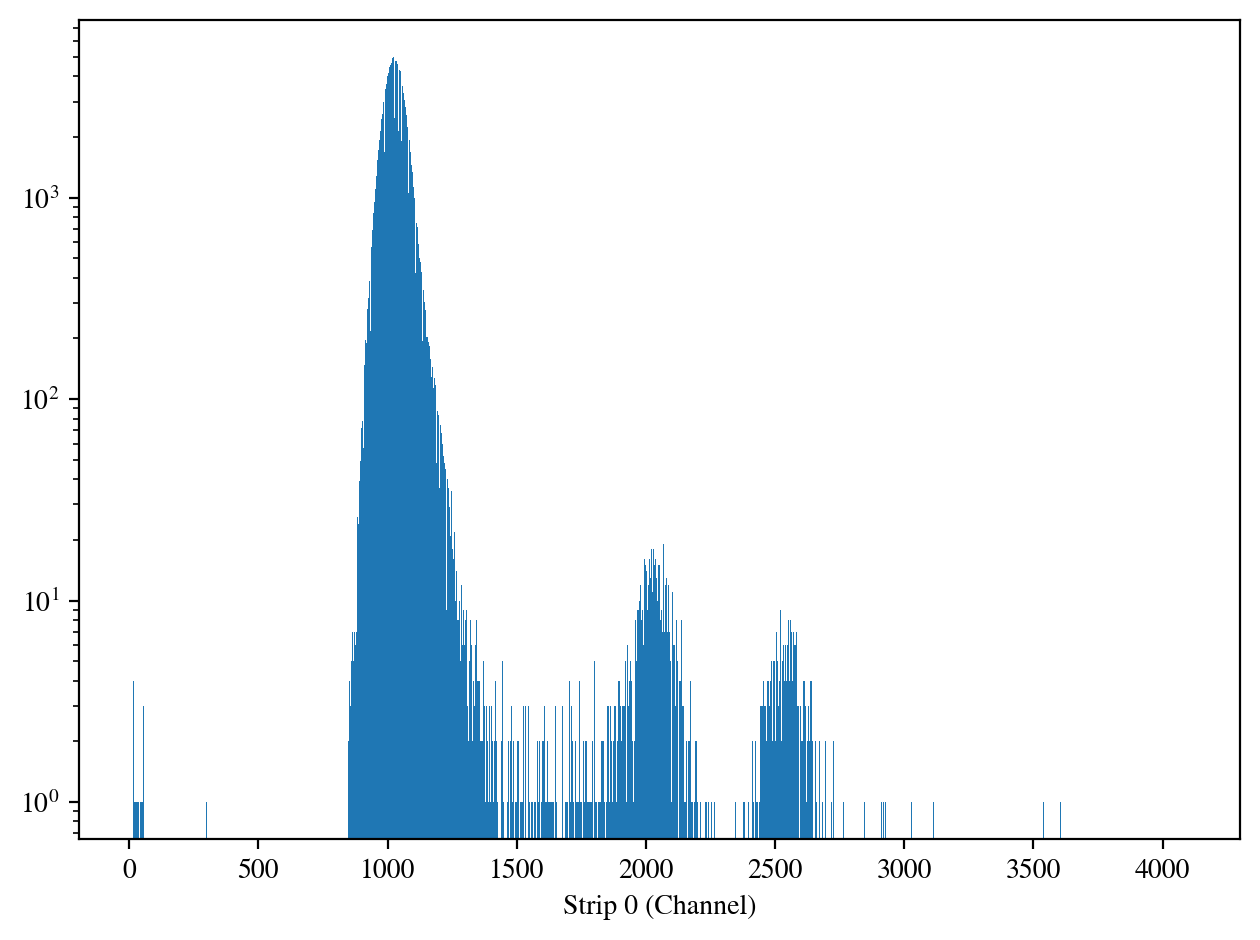

In [6]:
plt.hist(df['s0'], bins='auto')
plt.xlabel('Strip 0 (Channel)')

plt.yscale('log')

plt.tight_layout()
plt.show()

We see a large peak around channel 1000 and the next "most prominent" peak is around channel 2000. If our beam is the peak at channel 1000 then two particles of beam entering MUSIC at the same time will give a $\Delta$E of around 2000. These are the pile-up events that we wish to remove from our dataset. For this kind of simple cut (1D cut) we can use the pandas drop function just like we did in the previous example. However, we are left with one important choice, where to place the upper and lower limits for the cut. Here, since this dataset is very small (statistics are not great) when we put the y-axis on a log scale combined with the choice of the auto binning from numpy makes it appear as though our "beam peak" around channel 1000 is sufficently distinct from the nearest "large" peak at channel 2000. For real datasets, with much larger statistics, this would be highly unlikley and a fair amount of thought needs to go into where to make the cuts. 

For example, you probably would want to fit the two peaks (at channel 1000 and 2000) with a Gaussian then plot those fits on top of the histogram here to aid in placing the upper and lower limits of the cut. Here we need only to remember that the matplotlib hist function uses numpy to get the bin locations and counts. Using the fitting tools in scipy we can take those bins and counts information and fit it with a Guassian. First, let's define the Gaussian function.

In [7]:
def gauss(x, a, mu, sigma):
    ''' Non-normalized Guassian function.
    
    Parameters
    ----------
    x : float
        Point to evaluate function at.
    a : float
        Height of curve at center.
    mu : float
        Location of center of curve.
    sigma : float
        Standard deviation.
            
    Returns
    -------
    out : float
        Value of function.
    '''
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

In [8]:
from scipy.optimize import curve_fit

From scipy we will use the curve_fit function in the optimize toolset. From the function we just defined (gauss) we want scipy to optimize the "a", "mu" and "sigma" parameters. Which means we will need two sets of initial guesses (one for the channel 1000 peak and the other for the channel 2000 peak). Remember, the initial guess does require some care as curve_fit uses non-linear least squares approach.

Lets get the explicit bin location and counts from our histogram plot. Then, just to make things easier, we will get the center of the bins (matplotlib hist gives the left edge of the bin, except for the final bin where it give the right edge). Then use curve_fit to optimize parameters to fit the two peaks.

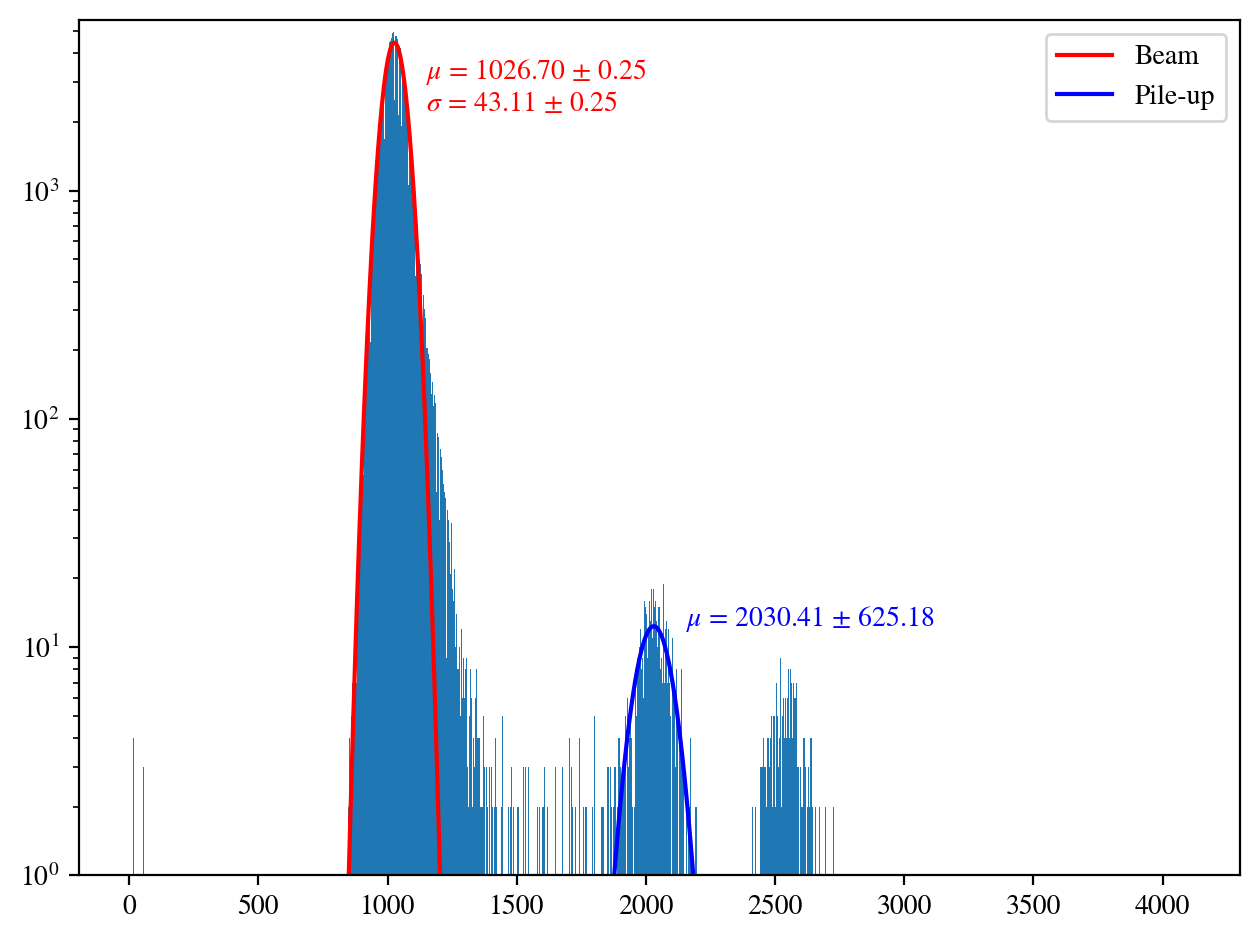

In [9]:
counts, bins, patches = plt.hist(df['s0'], bins='auto')

# Get center of bins
center_bins = (bins[:-1] + np.diff(bins) / 2)
# Fit peak at channel 1000
param_1, cov_1 = curve_fit(gauss, center_bins, counts,
                       p0=(4800, 1000, 50)) # initial guesses for peak at 1000
# Fit peak at channel 2000
param_2, cov_2 = curve_fit(gauss, center_bins, counts,
                       p0=(20, 2000, 50)) # initial guesses for peak at 2000
# Plot Guassian curves
x_values_to_fit = np.linspace(500,3000,1000)
plt.plot(x_values_to_fit, gauss(x_values_to_fit, *param_1), '-', color = 'red', lw=1.5, label = "Beam")
plt.plot(x_values_to_fit, gauss(x_values_to_fit, *param_2), '-', color = 'blue', lw=1.5, label = "Pile-up")
# Put some parameters on graph
plt.text(param_1[1] + 100, param_1[0] - 0.5*param_1[0],
         f' $\mu$ = %.2f $\pm$ %.2f \n $\sigma$ = %.2f $\pm$ %.2f' % (param_1[1],
                                                                      np.sqrt(cov_1[1,1]),
                                                                      param_1[2],
                                                                      np.sqrt(cov_1[2,2])),
         color='red')
plt.text(param_2[1] + 100, param_2[0],
         f' $\mu$ = %.2f $\pm$ %.2f' % (param_2[1],
                                        np.sqrt(cov_2[1,1])),
         color='blue')

plt.yscale('log')
plt.ylim(1,5600)

plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
A few things about the above plot. First, we are using the square-root of the diagional elements of the covariance matrix from our curve_fit to get error bars for the parameters values we are putting in the plot. Since we are just fitting a histogram, in this case these error bars are fine. In general, this does not get you the "true" error bars, if the data your fitting itself has errorbars you would need to incorporate that information into the fit and the resulting confidence of the parameters. Just something to remember. Second, our y-axis is in a log-scale. The "blue" peak is very small, and therefore we shouldn't be surprised that the error bars for $\mu$ of the blue curve is quite large. This is also why I ommited the $\sigma$ for the blue curve, if you replot this with the y-axis on a linear scale the peak at 2000 is a mere blip.</div>

The peak at channel 1000 is fairly distinct from the peak at channel 2000. If we take the $\mu$ of the red curve and add two $\sigma$ to it (even including the maximum error) we get something around channel 1114 which is still far away from the blue curve. Lets set the lower value of our cut at channel 500 and the upper value of the cut at channel 1114. A good habbit to get into is to apply the cuts to a copy of the original dataframe (that way you always have both the cut and uncut data ). One way to do this is to use the "inplace" option.

In [10]:
# Note here the usage of the drop function. It seems backward at first, but checking the 
# dockstring the binary operator is the right way round

strip_0_cut = df.drop(df[500 > df.s0].index, # Nothing with strip 0 smaller than 500
                      inplace=False) # Do not make cut "inplace", make a copy of df called strip_0_cut first and cut on the copy
strip_0_cut.drop(strip_0_cut[strip_0_cut.s0 > 1114].index, # Nothing with strip 0 larger than 1114
                                inplace=True) # Do not make copy, make the cut "inplace"

strip_0_cut.describe()

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17,grid
count,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,...,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000,252650.000000
mean,1024.407593,349.425781,49.759960,36.895653,353.400391,365.808472,34.902157,37.019974,364.689667,401.401855,...,431.489288,37.836205,52.353367,441.170868,451.488464,35.252132,63.495564,432.270935,394.830872,1502.750488
std,40.848080,14.949363,9.006007,5.162974,15.922771,16.214216,6.547119,8.791202,17.919319,18.718981,...,24.891680,17.412069,59.178932,69.749413,28.064951,20.757408,74.794601,82.984840,15.948725,72.729027
min,537.000000,35.000000,33.000000,31.000000,36.000000,36.000000,28.000000,30.000000,31.000000,37.000000,...,33.000000,31.000000,29.000000,33.000000,34.000000,29.000000,31.000000,33.000000,27.000000,10.000000
25%,997.000000,340.000000,42.000000,36.000000,344.000000,356.000000,34.000000,36.000000,355.000000,391.000000,...,422.000000,36.000000,35.000000,441.000000,442.000000,33.000000,38.000000,436.000000,385.000000,1460.000000
50%,1025.000000,350.000000,50.000000,37.000000,354.000000,366.000000,35.000000,37.000000,365.000000,402.000000,...,432.000000,37.000000,37.000000,459.000000,453.000000,34.000000,40.000000,457.000000,395.000000,1501.000000
75%,1053.000000,359.000000,56.000000,38.000000,364.000000,376.000000,36.000000,38.000000,375.000000,413.000000,...,443.000000,38.000000,38.000000,473.000000,464.000000,35.000000,43.000000,471.000000,404.000000,1544.000000
max,1114.000000,693.000000,396.000000,625.000000,877.000000,869.000000,569.000000,426.000000,1028.000000,979.000000,...,1126.000000,1098.000000,849.000000,1229.000000,1129.000000,798.000000,1084.000000,1228.000000,951.000000,2679.000000


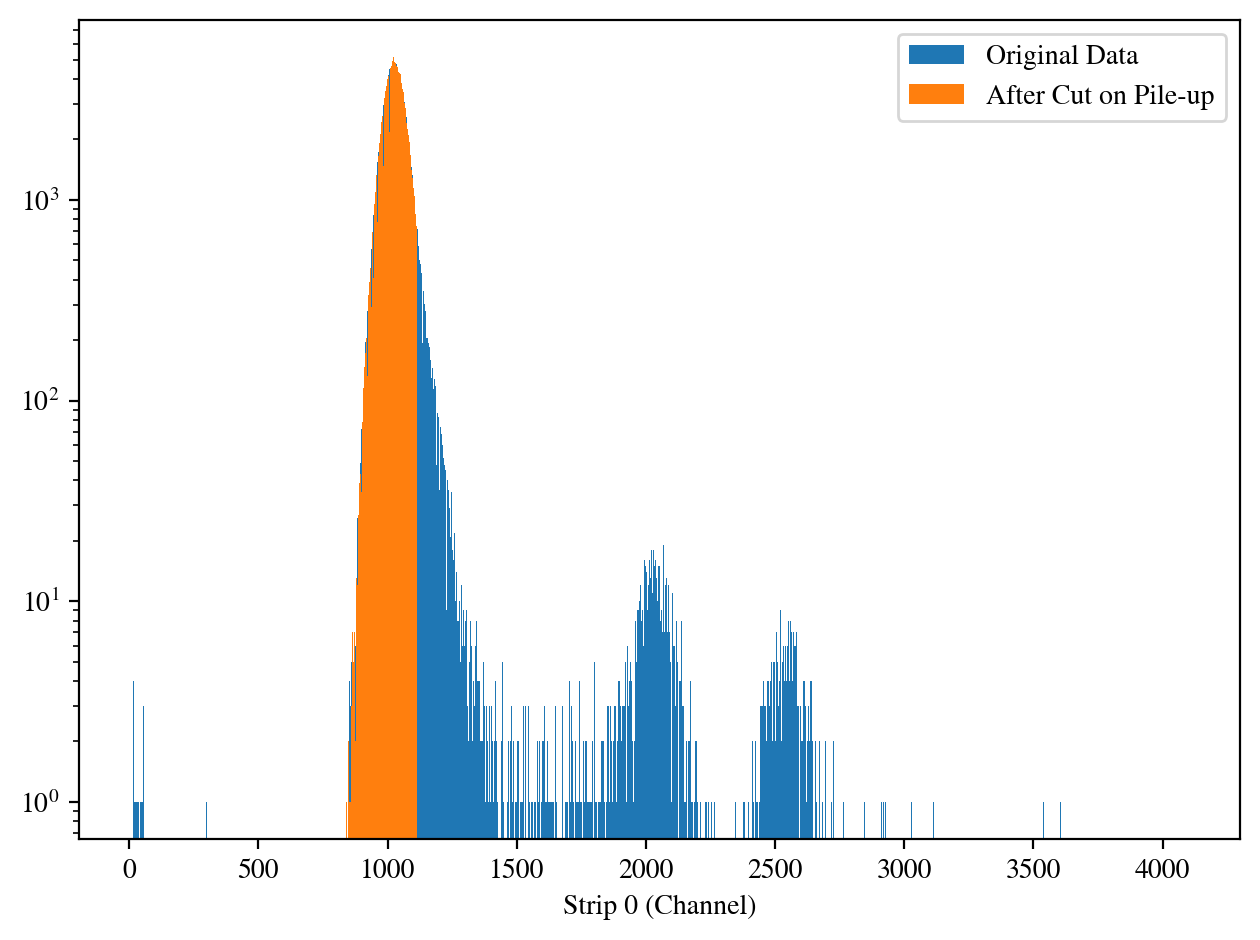

In [11]:
plt.hist(df['s0'], bins='auto',
         label='Original Data')
plt.hist(strip_0_cut['s0'], bins='auto',
         label='After Cut on Pile-up')

plt.xlabel('Strip 0 (Channel)')
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

Notice, after our cut we still have what looks like a "wing" of events to the right of our upper cut limit. We made our cut based on the Gaussian fit (using $\mu$ plus two times the $\sigma$ of the Gaussian as a rough guide). Here, thas was just to demonstrate making a cut, not necessarily if this is the best possible cut for this data set. Double checking where you place cuts and how that could influence your anaylsis is something that kind of needs to be handled on a case by case basis.  For this example we can move onto the next part.

# Normalizing the Anode Data

So far, we have only looked at strip 0. After making the cut to remove the pile-up events, we should take a look at the other histograms for the other strips. For simplicity lets look at the next 8 long strips after strip 0. 

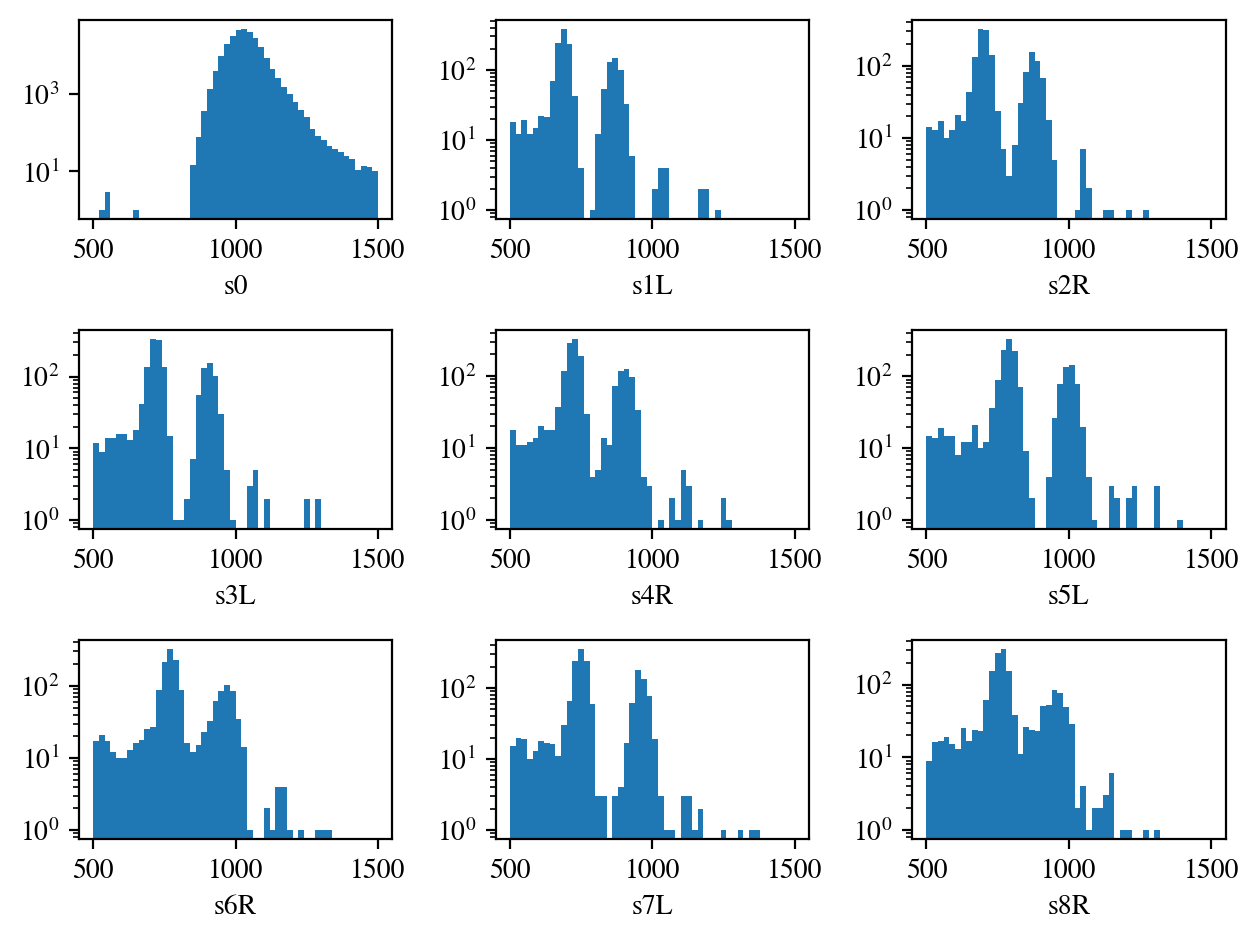

In [31]:
labels = ['s0', 's1L', 's2R', 's3L', 's4R', 's5L', 's6R', 's7L', 's8R']

fit, ax = plt.subplots(3,3)

for i in range(3):
    # top row
    ax[0,i].hist(df[labels[i]], bins=50, range=[500,1500])
    ax[0,i].set_xlabel(labels[i])
    ax[0,i].set_yscale('log')
    # middle row
    ax[1,i].hist(df[labels[i+3]], bins=50, range=[500,1500])
    ax[1,i].set_xlabel(labels[i+3])
    ax[1,i].set_yscale('log')
    # bottom row
    ax[2,i].hist(df[labels[i+6]], bins=50, range=[500,1500])
    ax[2,i].set_xlabel(labels[i+6])
    ax[2,i].set_yscale('log')
    
plt.tight_layout()
plt.show()

In the top left histogram we see strip 0 has the peak at 1000 and, aside from some skew towards higher channels, the distribution looks pretty Gaussian. However, looking at the remaining histograms we see not one but two peaks. Of these two peaks, the most prominent one is not always centered at the same channel for these segmented anode strips. The most likely signal in all of the strips should be the unreacted beam. For this experiment we know

- The strips are all the same width
- The electric field should be sufficiently uniform (let's just take this as is for now, depending on beam rate and gas density the dynamics of the ions and electric field can get complicated)
- The beam did not enter MUSIC at any appreciable angle
- The unreacted beam does not stop inside MUSIC 

then one could expect the unreacted beam to create a $\Delta$E signal in all of the strips centered at roughly the same channel. Which we don't see in the histograms we plotted above. Then we will normalize our dataset using the unreacted beam signal in each of the anode strips. But, remember we have long strips (which see the unreacted beam) and short strips (which should not see the unreacted beam). Surely if there are differences in the gain of the long strips, there is differences in the gain for the short strips as well which we should "correct for" also. How do we handle this? Now we are getting into the nitty-gritty aspects of normalization. The short answer is, you need to try different normilzation schemes for your data set and see what gives a consistent result you are looking for. So, what we are going to do here won't always work. Though, the method we will use here is typically a good first thing to try on most MUSIC datasets. 

We will sum the left and right strips (s1L + s1R, s2L+s2R, etc...) and then normalize the summed data, using the unreacted beam peak, of each strip to some value of our choosing (say, 1000). First, let's create a new dataframe which has the left and right anode strips summed along the detector. Similar to how we build some of the dataframes in example 1, we can do this with a dictionary.

### Changing to Summed Strip DataFrame

In [24]:
dict = {'s0':df['s0'], 's1':df['s1L']+df['s1R'], 's2':df['s2L']+df['s2R'], 's3':df['s3L']+df['s3R'], 's4':df['s4L']+df['s4R'],
        's5':df['s5L']+df['s5R'], 's6':df['s6L']+df['s6R'], 's7':df['s7L']+df['s7R'], 's8':df['s8L']+df['s8R'],
        's9':df['s9L']+df['s9R'], 's10':df['s10L']+df['s10R'], 's11':df['s11L']+df['s11R'], 's12':df['s12L']+df['s12R'],
        's13':df['s13L']+df['s13R'], 's14':df['s14L']+df['s14R'], 's15':df['s15L']+df['s15R'], 's16':df['s16L']+df['s16R'],
        's17':df['s17'], 'grid': df['grid']}

df_sum = pd.DataFrame(dict)

df_sum

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,grid
0,1003.0,416.0,401.0,420.0,377.0,410.0,411.0,417.0,433.0,456.0,451.0,426.0,497.0,497.0,492.0,495.0,494.0,402.0,1522.0
1,1091.0,397.0,403.0,408.0,397.0,398.0,436.0,392.0,410.0,408.0,449.0,458.0,465.0,466.0,563.0,502.0,522.0,380.0,1468.0
2,1083.0,426.0,395.0,406.0,410.0,394.0,406.0,401.0,427.0,443.0,444.0,441.0,485.0,484.0,539.0,503.0,522.0,402.0,1421.0
3,1002.0,405.0,378.0,394.0,417.0,441.0,435.0,428.0,401.0,443.0,451.0,458.0,506.0,472.0,479.0,503.0,504.0,400.0,1450.0
4,1015.0,393.0,398.0,410.0,421.0,439.0,413.0,411.0,438.0,391.0,422.0,451.0,479.0,477.0,478.0,476.0,506.0,366.0,1487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,401.0,396.0,418.0,413.0,450.0,444.0,405.0,407.0,423.0,423.0,446.0,492.0,464.0,467.0,454.0,498.0,403.0,1592.0
267825,969.0,366.0,396.0,422.0,399.0,444.0,383.0,419.0,419.0,413.0,419.0,450.0,469.0,475.0,496.0,482.0,517.0,384.0,1559.0
267826,958.0,376.0,395.0,394.0,398.0,432.0,415.0,402.0,411.0,430.0,434.0,465.0,473.0,459.0,481.0,456.0,497.0,398.0,1439.0
267827,1006.0,383.0,371.0,430.0,400.0,447.0,419.0,402.0,393.0,411.0,407.0,428.0,475.0,471.0,498.0,489.0,442.0,393.0,1524.0


### Normalizing By Fitting Gaussian to Unreacted Beam Peak

To get the factor we will apply to each strip to normalize the unreacted beam to 1000, we can fit the histogram of each strip by a Gaussian and from the center parameter derive a multiplicative factor to scale each strip. So we can see how this changes the data we can print some quick statistics about each column of the above summed dataframe with the "describe" function.

In [25]:
df_sum.describe()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,grid
count,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000,267829.000000
mean,1038.657715,401.676178,392.891571,403.270874,404.368042,435.799713,425.979523,415.094208,416.411316,425.332642,444.009125,444.303131,477.411560,472.466309,497.298431,490.032898,500.038818,397.822144,1511.638062
std,108.757195,35.354321,35.540485,36.051582,36.606739,39.951569,39.720547,38.520462,39.598698,39.501915,42.812569,41.479839,45.874718,44.404163,49.514599,46.900097,51.737446,41.927620,152.078690
min,10.000000,71.000000,69.000000,67.000000,65.000000,65.000000,65.000000,62.000000,62.000000,66.000000,65.000000,67.000000,67.000000,67.000000,68.000000,66.000000,67.000000,26.000000,10.000000
25%,999.000000,389.000000,381.000000,391.000000,392.000000,422.000000,412.000000,402.000000,403.000000,412.000000,430.000000,431.000000,462.000000,459.000000,480.000000,476.000000,481.000000,386.000000,1459.000000
50%,1028.000000,400.000000,391.000000,401.000000,402.000000,434.000000,424.000000,413.000000,414.000000,423.000000,442.000000,442.000000,475.000000,470.000000,496.000000,487.000000,498.000000,395.000000,1501.000000
75%,1059.000000,411.000000,401.000000,411.000000,412.000000,444.000000,435.000000,423.000000,426.000000,433.000000,454.000000,452.000000,488.000000,481.000000,510.000000,498.000000,513.000000,405.000000,1545.000000
max,4095.000000,1759.000000,1793.000000,1805.000000,1866.000000,2522.000000,2496.000000,2481.000000,2479.000000,2636.000000,2805.000000,2690.000000,2453.000000,2291.000000,2390.000000,2481.000000,2461.000000,2134.000000,4095.000000


Now, we fit the histogram of each strip using a Guassian just like we did before we did the cut in strip 0. The one thing we need to remember is we need to be mindful of our initial guesses for the curve_fit function. For this simple example, I'm just going to enter some parameters by hand (basically, look at each histogram and make reasonable guesses). There are ways to "automate" this guessing of the initial parameters, but that's something one can handle after you've done a couple sets by hand first.

In [49]:
norm_factor = []
norm_to = 1000.0
mu_guess = [1000.0, 380.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 420.0, 425.0,
            430.0, 435.0, 445.0, 455.0, 465.0, 475.0, 485.0, 380.0]

# Normalize a copy of the original dataframe
df_sum_norm = df_sum.copy()
# Da loop
for i in range(0,18):
    mean_gauss = 0.0
    counts, bins, patches = plt.hist(df_sum_norm.iloc[:, i], bins=60) # !
    cen_bins = (bins[:-1] + np.diff(bins) / 2)
    # Fit
    param, cov = curve_fit(gauss, cen_bins, counts,
                           p0=(35000, mu_guess[i], 25))
    # Get Mean of Gauss
    mean_gaus = param[1]
    # normalize
    norm_factor.append(norm_to/mean_gaus)
    df_sum_norm.iloc[:, i] = df_sum_norm.iloc[:, i]*(norm_to/mean_gaus)
    # Close
    plt.close()
    
print(norm_factor)

[0.9743237256055246, 2.502252504753123, 2.5622786210336206, 2.493953715037408, 2.489219410063631, 2.3065206537756886, 2.3579421546414405, 2.4194889448728354, 2.4141678228804917, 2.3701541501076586, 2.267799597916459, 2.263685525759758, 2.1055696954393333, 2.1279895751460574, 2.012345493892392, 2.053817830862121, 2.010328825467374, 2.5320472023360425]


We can do a quick side-by-side plot to see what our normalization looks like.

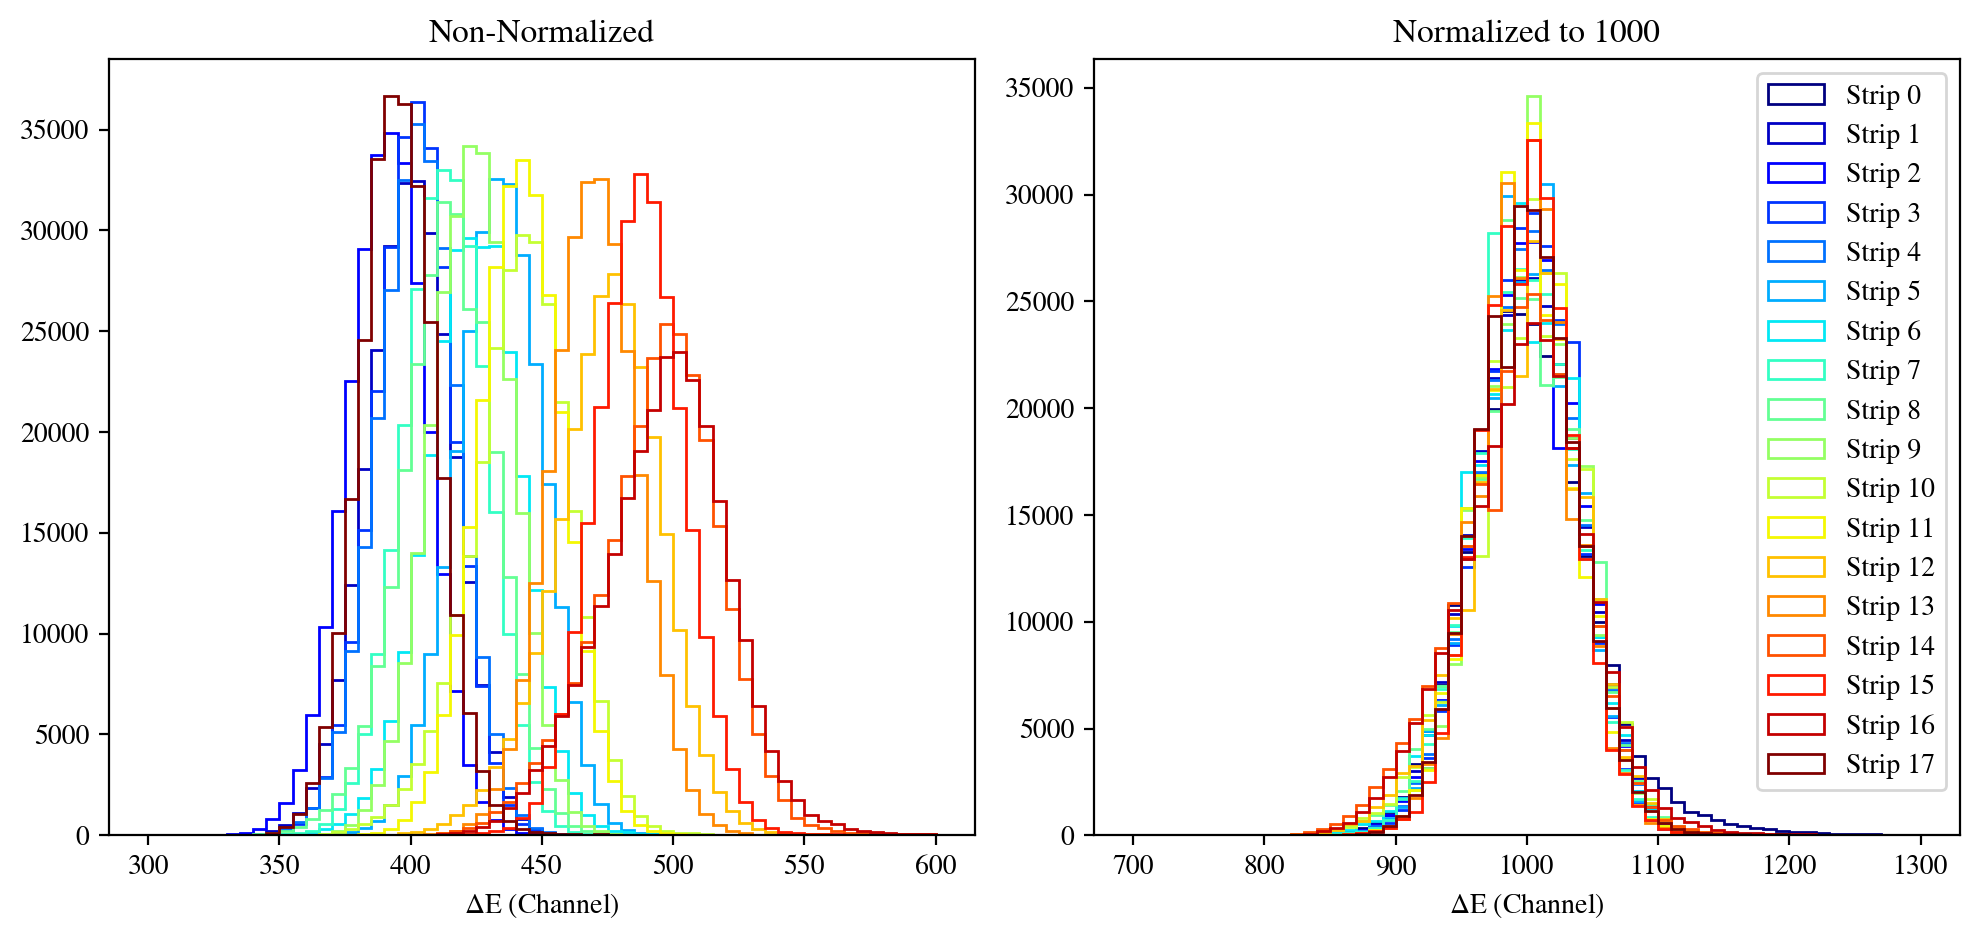

In [53]:
disc_jet = plt.cm.jet(np.linspace(0,1,18)) # Setup cmap so each histogram is unique color from jet

fig, ax = plt.subplots(1,2)
fig.set_figwidth(10,6)

for i in range(0,18):
    # Raw Data
    ax[0].hist(df_sum.iloc[:,i].values, bins=60, 
               range=[300, 600], 
               histtype='step',
               color=disc_jet[i],
               label=f'Strip {i}')
    # Normalized Data
    ax[1].hist(df_sum_norm.iloc[:,i].values, bins=60, 
               range=[700, 1300], 
               histtype='step',
               color=disc_jet[i],
               label=f'Strip {i}')

ax[0].set_title('Non-Normalized')
ax[0].set_xlabel(r'$\Delta$E (Channel)')

ax[1].set_title('Normalized to 1000')
ax[1].set_xlabel(r'$\Delta$E (Channel)')
ax[1].legend()

plt.tight_layout()
plt.show()